# Imports

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter, resample
from tensorflow.keras.layers import Input

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler,StandardScaler

from scipy.stats import pearsonr
import seaborn as sns

2025-04-23 14:12:24.230119: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-23 14:12:24.784728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745410344.966735   30950 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745410345.022343   30950 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745410345.447194   30950 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Load Data

In [2]:
# Dataset ID
date_id = "20250319"
record_id = "200"
segment_length = 48

# Path to dataset folder
dataset_path = f"../../../datasets/xydataset/csv/s{date_id}/s{date_id}_{record_id}/{segment_length}"

# Load CSVs
X_train = pd.read_csv(f"{dataset_path}/x_train.csv").values
X_test = pd.read_csv(f"{dataset_path}/x_test.csv").values
y_train = pd.read_csv(f"{dataset_path}/y_train.csv").values
y_test = pd.read_csv(f"{dataset_path}/y_test.csv").values

# Reshape X to (samples, timesteps, features) for LSTM
X_train = X_train.reshape(-1, segment_length, 1)
X_test = X_test.reshape(-1, segment_length, 1)

print("Loaded shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Loaded shapes:
X_train: (799, 48, 1)
y_train: (799, 1)
X_test: (199, 48, 1)
y_test: (199, 1)


# Plot Loaded Data (4 Subplots)

<IPython.core.display.Javascript object>


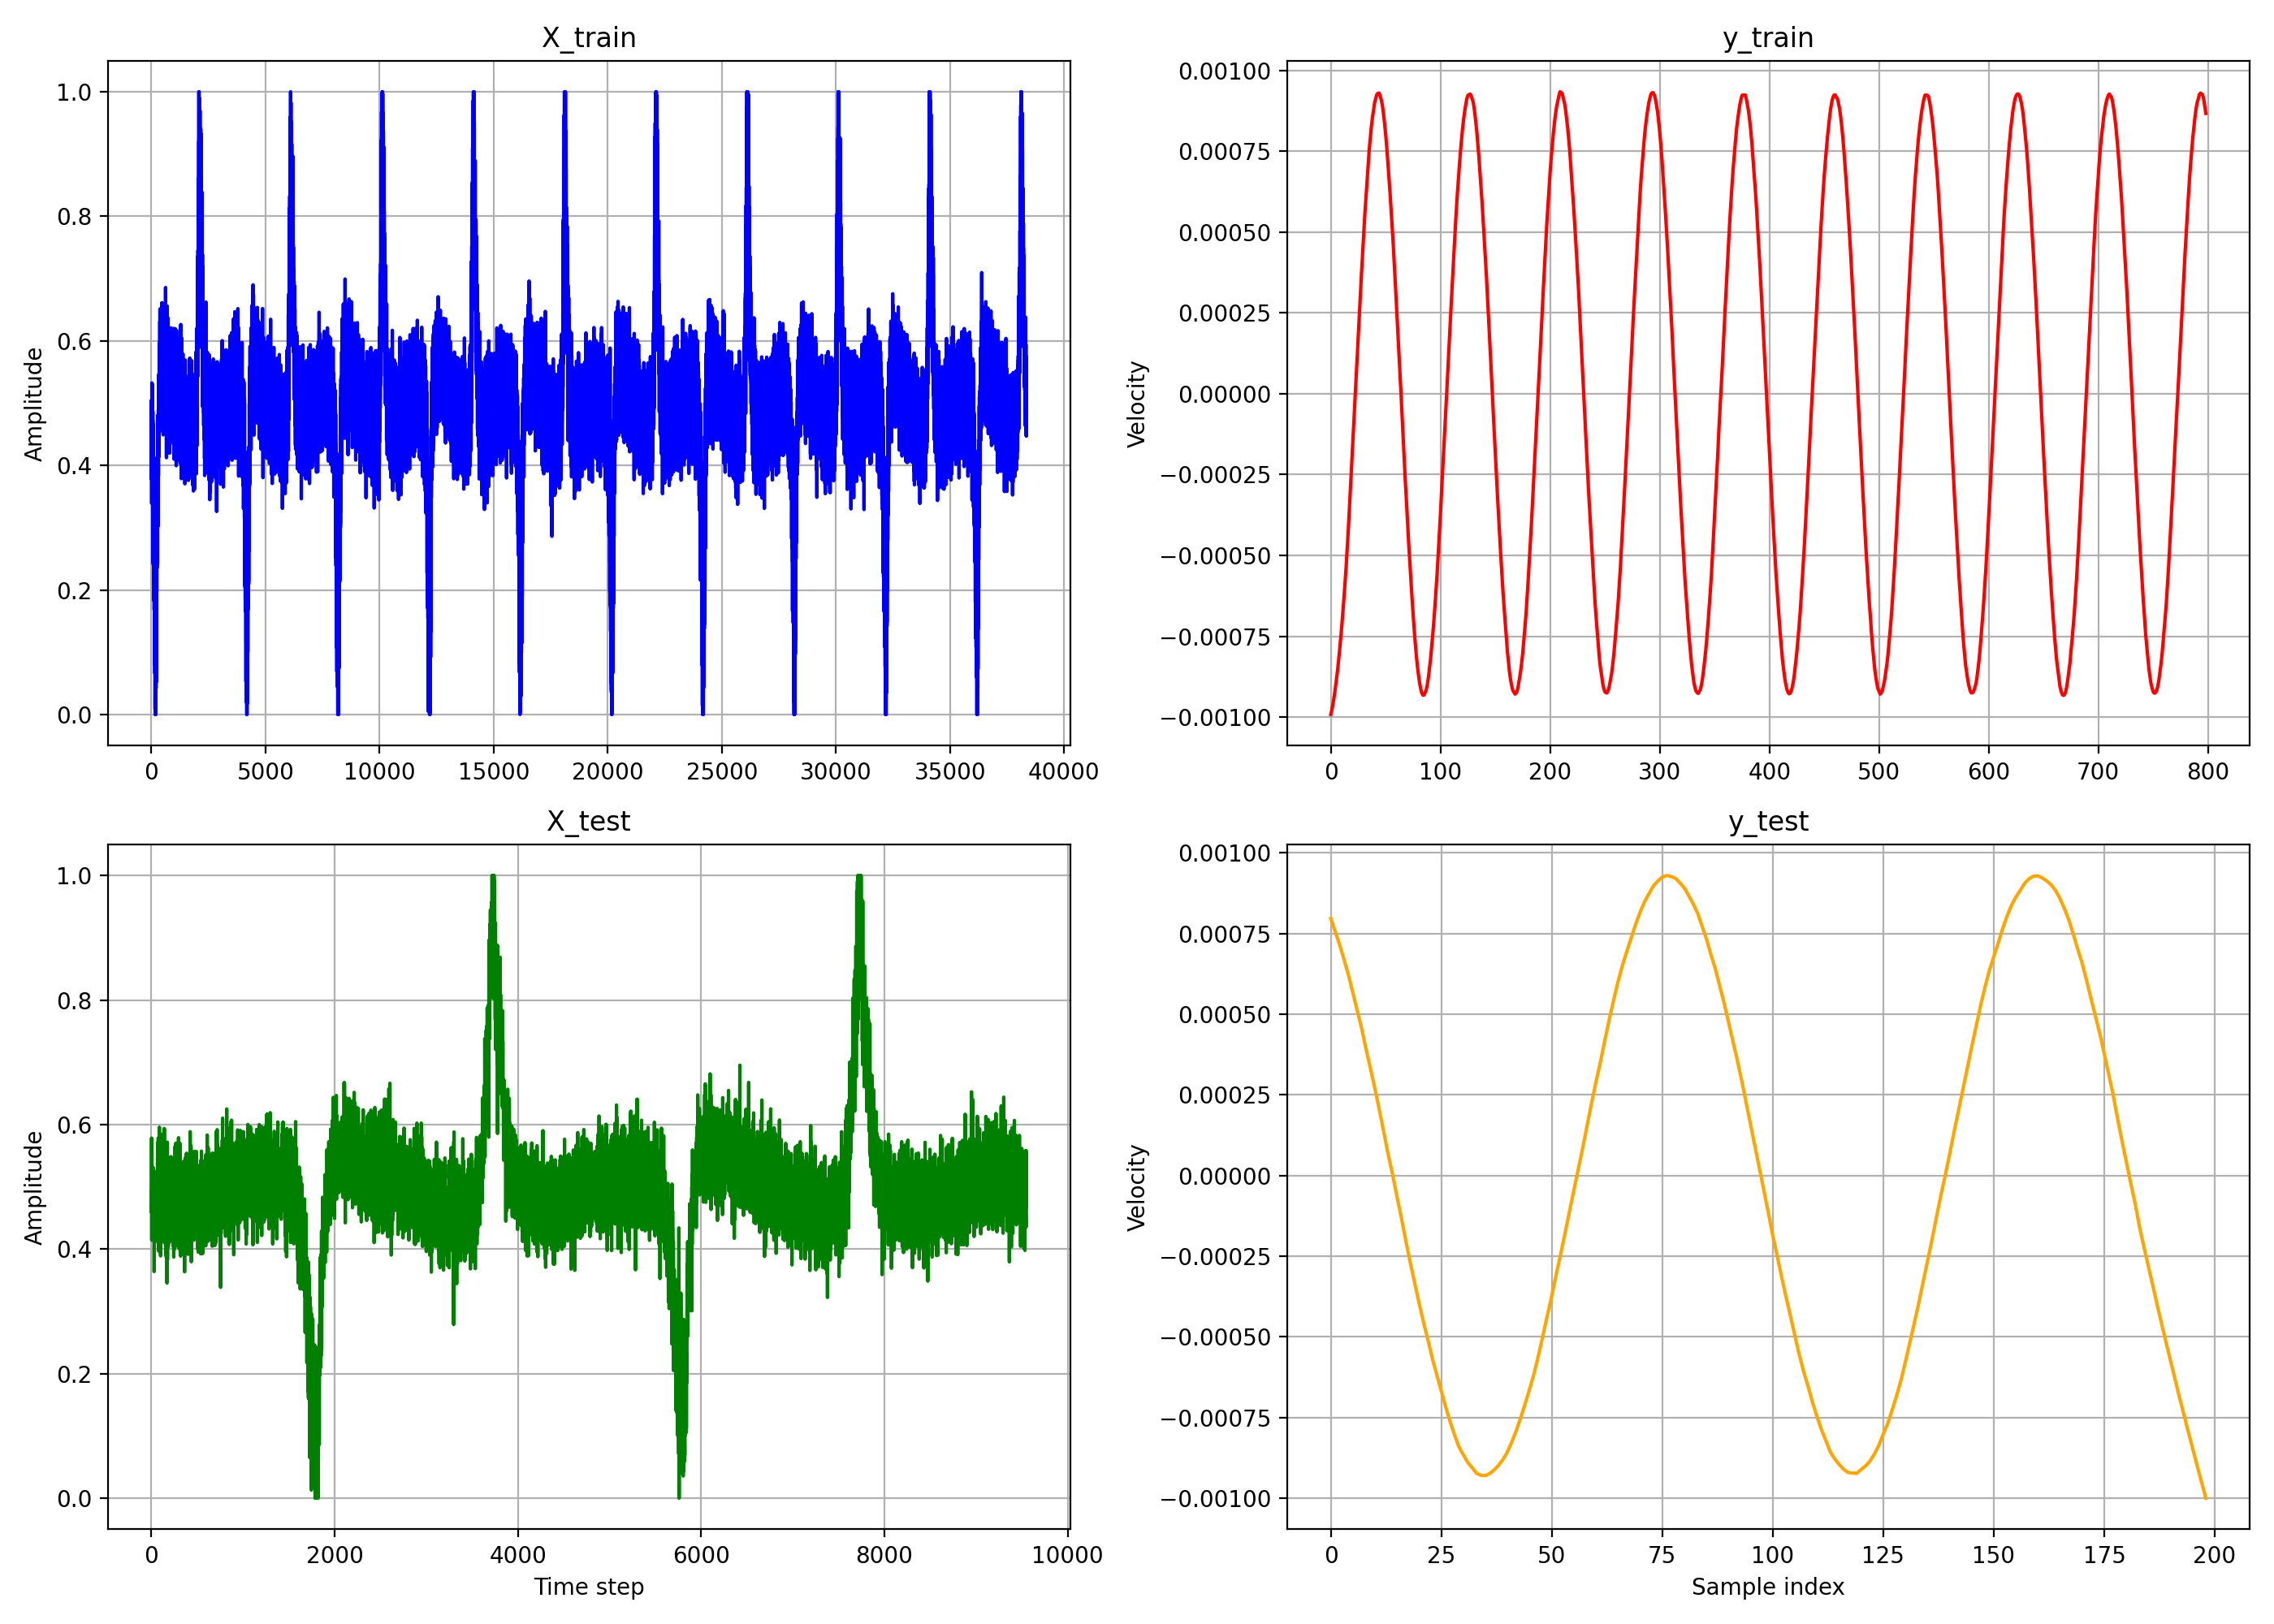

In [3]:
# Flatten for continuous plotting
X_train_cont = X_train.squeeze().flatten()
X_test_cont = X_test.squeeze().flatten()
y_train_cont = y_train.flatten()
y_test_cont = y_test.flatten()

# Create time axes
t_X_train = np.arange(len(X_train_cont))
t_X_test = np.arange(len(X_test_cont))
t_y_train = np.arange(len(y_train_cont))
t_y_test = np.arange(len(y_test_cont))

# Plot the data
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(t_X_train, X_train_cont, color='blue')
plt.title("X_train")
plt.ylabel("Amplitude")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(t_y_train, y_train_cont, color='red')
plt.title("y_train")
plt.ylabel("Velocity")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(t_X_test, X_test_cont, color='green')
plt.title("X_test")
plt.xlabel("Time step")
plt.ylabel("Amplitude")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(t_y_test, y_test_cont, color='orange')
plt.title("y_test")
plt.xlabel("Sample index")
plt.ylabel("Velocity")
plt.grid(True)

plt.tight_layout()
plt.show()

# Scale data

In [62]:
scaling_method = ""

# Choose scalers based on method
if scaling_method == "minmax_01":
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))
elif scaling_method == "minmax_11":
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    scaler_y = MinMaxScaler(feature_range=(-1, 1))
else:  # Default to standard
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

# Apply scaling to X
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[1])).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[1])).reshape(X_test.shape)

# Apply scaling to y
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Plot scalled data

<IPython.core.display.Javascript object>


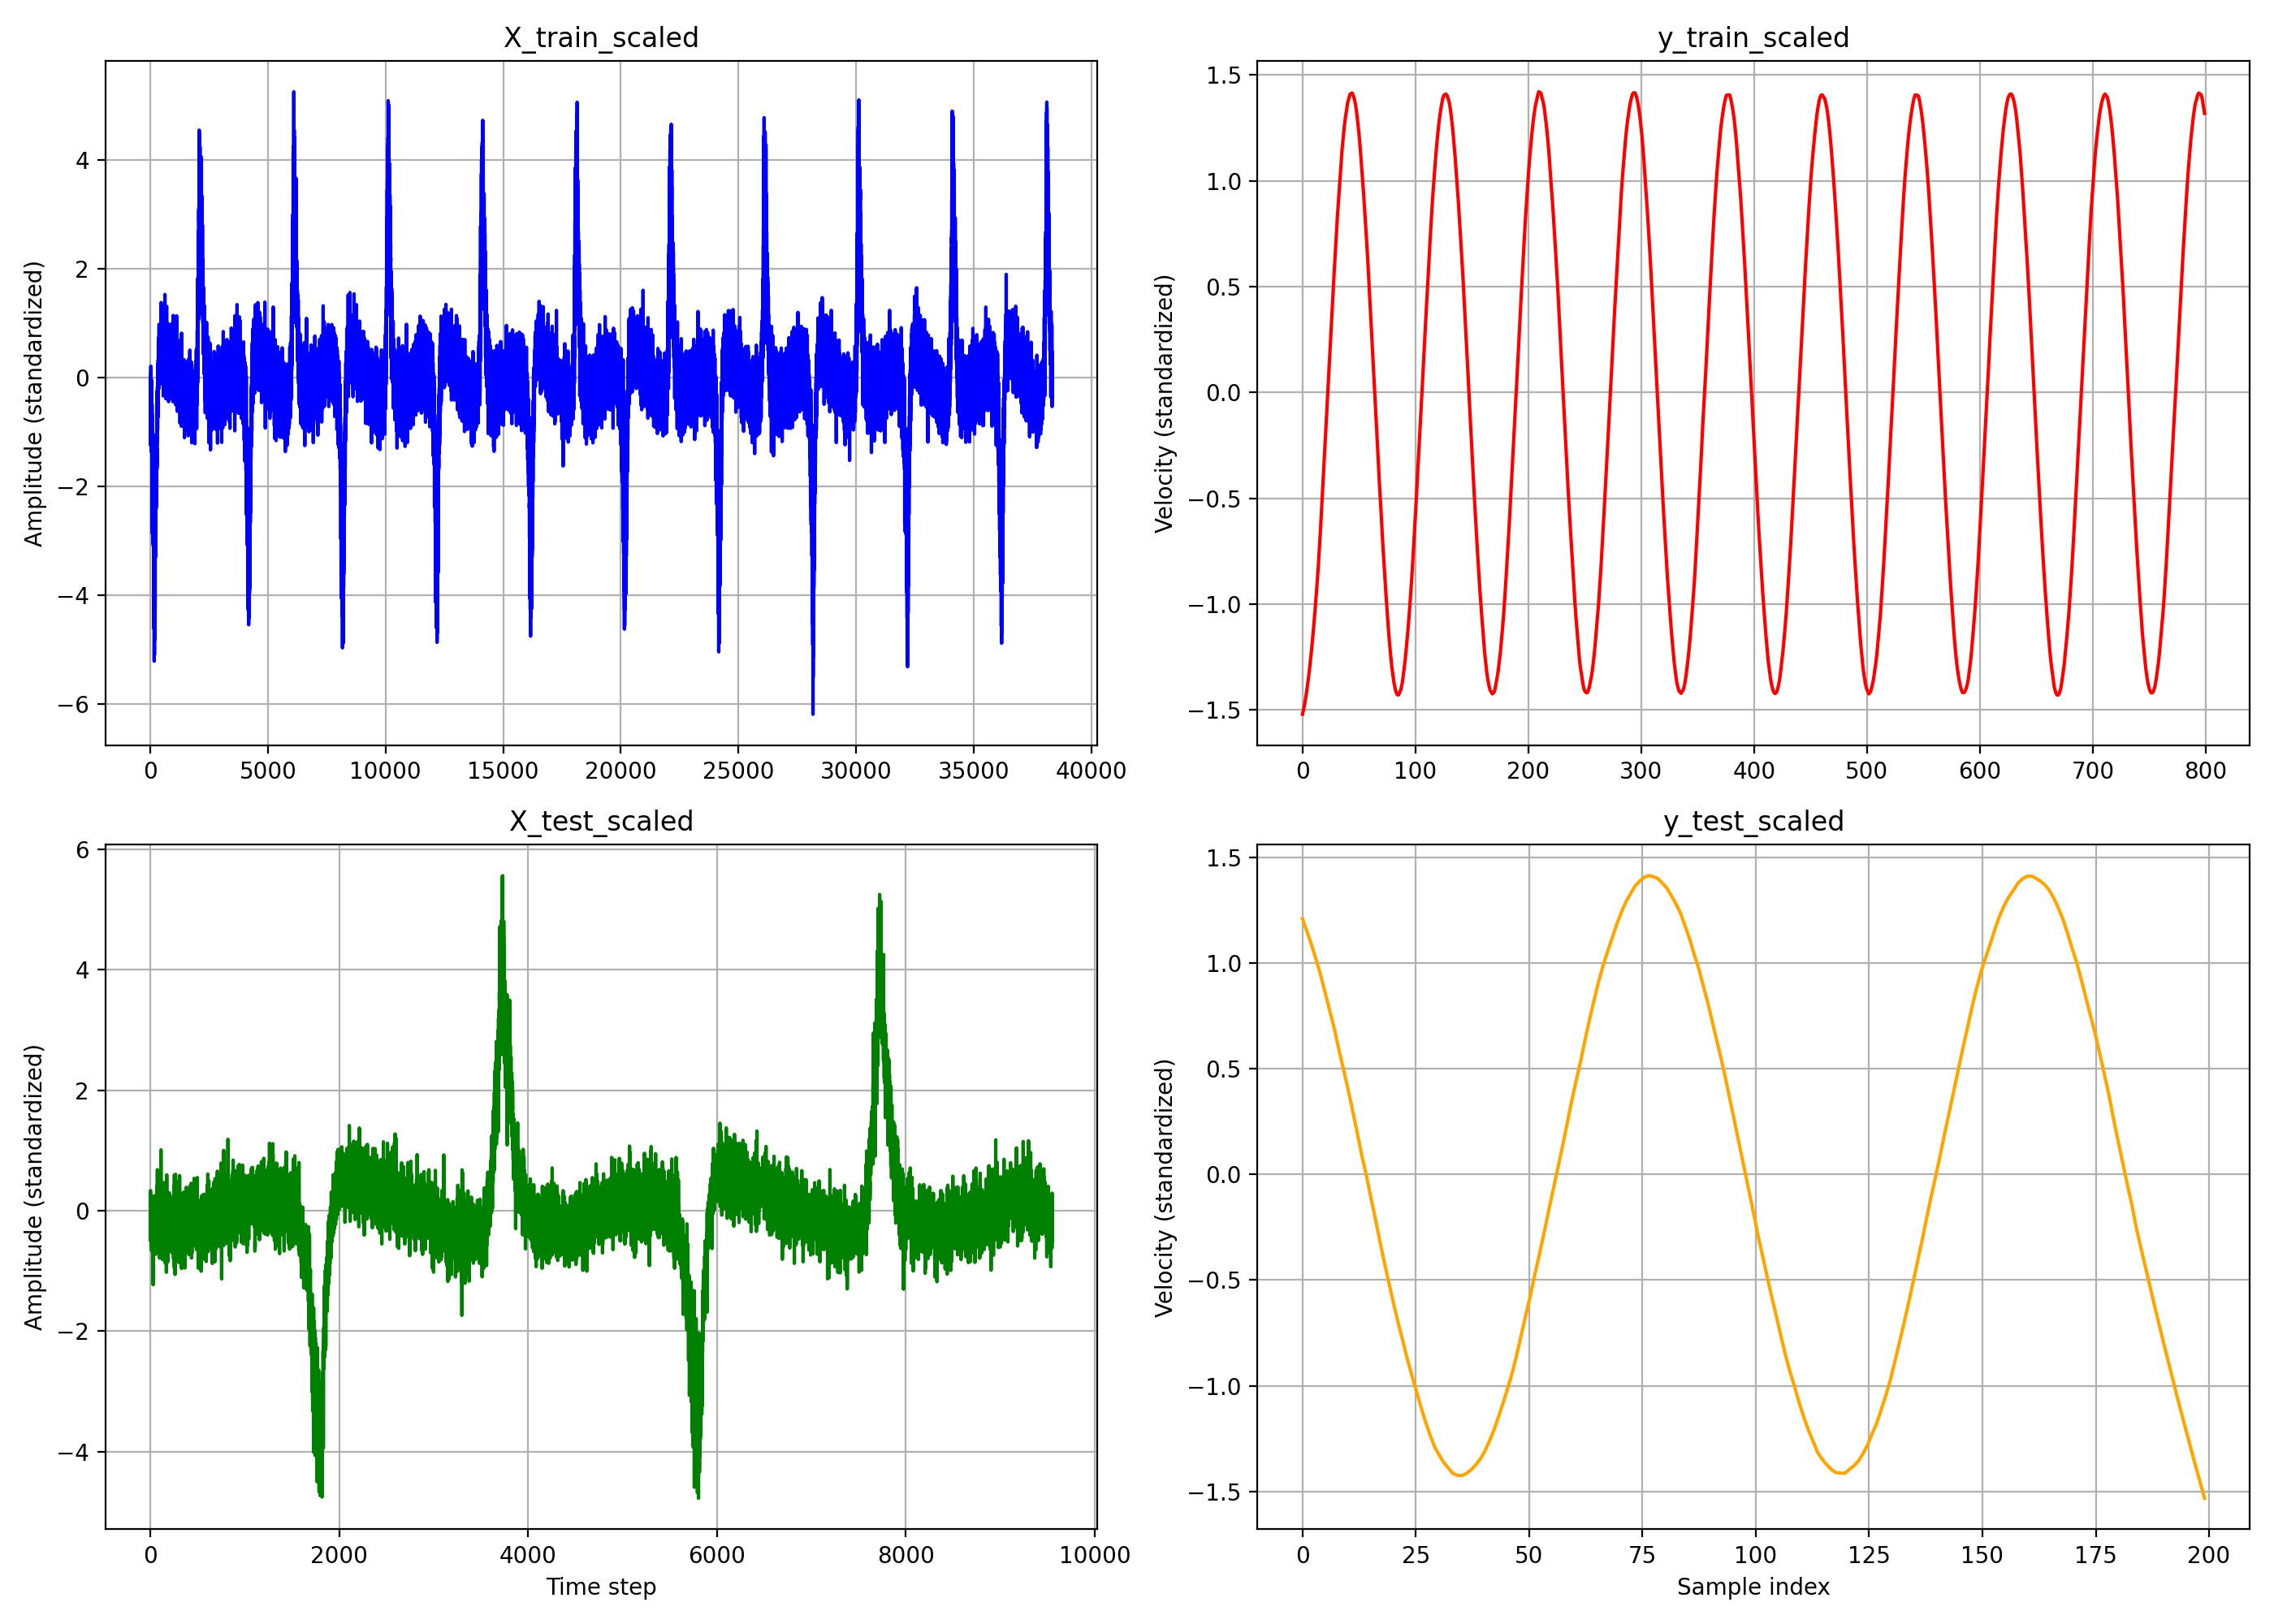

In [63]:
# Flatten the 3D inputs (X) for plotting
X_train_scaled_cont = X_train_scaled.reshape(-1)
X_test_scaled_cont = X_test_scaled.reshape(-1)
y_train_scaled_cont = y_train_scaled.flatten()
y_test_scaled_cont = y_test_scaled.flatten()

# Create time axes
t_X_train = np.linspace(0, len(X_train_scaled_cont), len(X_train_scaled_cont))
t_X_test = np.linspace(0, len(X_test_scaled_cont), len(X_test_scaled_cont))
t_y_train = np.linspace(0, len(y_train_scaled_cont), len(y_train_scaled_cont))
t_y_test = np.linspace(0, len(y_test_scaled_cont), len(y_test_scaled_cont))

# Plot
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(t_X_train, X_train_scaled_cont, color='blue')
plt.title("X_train_scaled")
plt.ylabel("Amplitude (standardized)")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(t_y_train, y_train_scaled_cont, color='red')
plt.title("y_train_scaled")
plt.ylabel("Velocity (standardized)")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(t_X_test, X_test_scaled_cont, color='green')
plt.title("X_test_scaled")
plt.xlabel("Time step")
plt.ylabel("Amplitude (standardized)")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(t_y_test, y_test_scaled_cont, color='orange')
plt.title("y_test_scaled")
plt.xlabel("Sample index")
plt.ylabel("Velocity (standardized)")
plt.grid(True)

plt.tight_layout()
plt.show()

# LSTM model

In [64]:
# Shape
segment_length = X_train.shape[1]
num_features = X_train.shape[2]

# Model
model = Sequential()
model.add(Input(shape=(segment_length, num_features)))
model.add(LSTM(16))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

# Compile
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Summary
model.summary()

# Get the total number of parameters in the model
total_params = model.count_params()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 16)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,297 (5.07 KB)

 Trainable params: 1,297 (5.07 KB)

 Non-trainable params: 0 (0.00 B)

# Train Model

In [65]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
use_early_stop=True

if(use_early_stop):
    history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    validation_data=(X_test_scaled, y_test_scaled),
    batch_size=16,callbacks=[early_stop]
    )
else:
        history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    validation_data=(X_test_scaled, y_test_scaled),
    batch_size=16
    )

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0020 - mae: 0.8819 - val_loss: 0.8224 - val_mae: 0.7981
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7892 - mae: 0.7764 - val_loss: 0.6912 - val_mae: 0.7037
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6995 - mae: 0.7036 - val_loss: 0.5455 - val_mae: 0.5905
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5521 - mae: 0.5814 - val_loss: 0.4701 - val_mae: 0.5169
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5226 - mae: 0.5253 - val_loss: 0.4365 - val_mae: 0.4804
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4773 - mae: 0.4899 - val_loss: 0.4801 - val_mae: 0.4950
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4590 - mae: 0.4646 - val_loss: 0.4445 - val_mae: 0.4760
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4113 - mae: 0.4378 - val_loss: 0.4539 - val_mae: 0.4750
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.426

# Plotting Loss and MAE

<IPython.core.display.Javascript object>


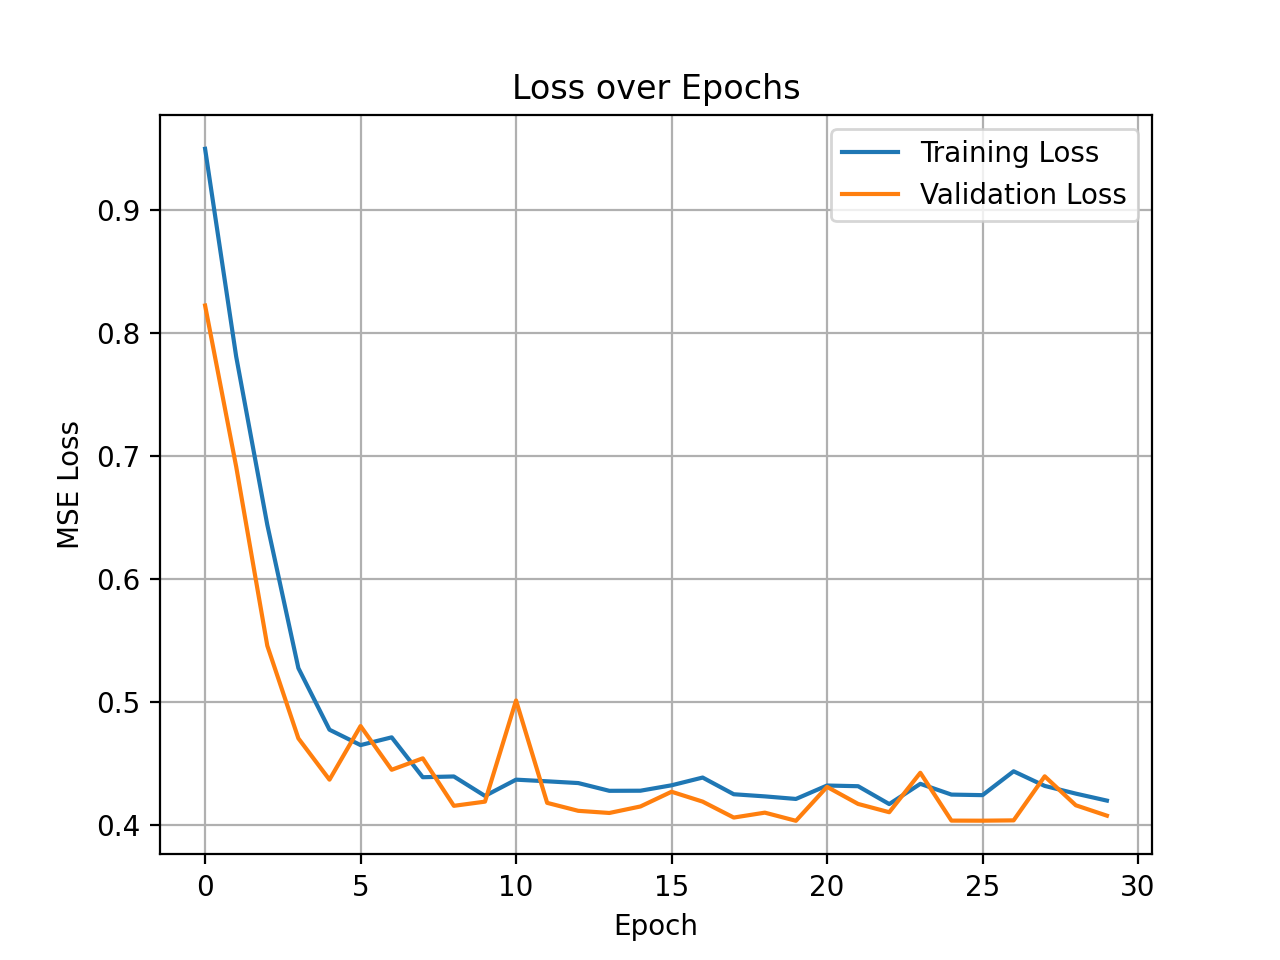

<IPython.core.display.Javascript object>


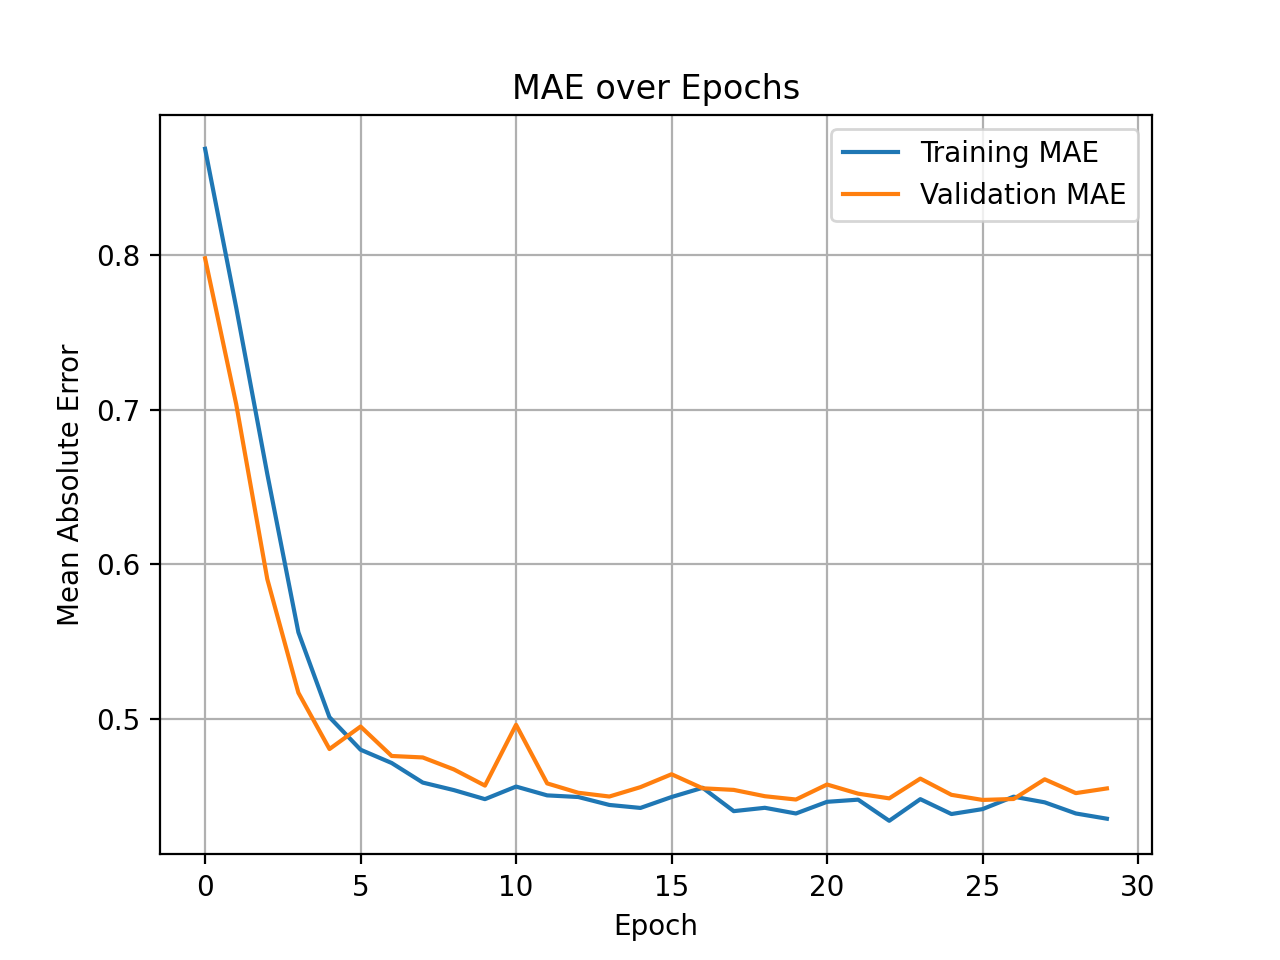

In [66]:
# Plot Loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot MAE
plt.figure()
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model

In [67]:
# Evaluate on test set
test_loss, test_mae = model.evaluate(X_test_scaled, y_test_scaled, verbose=1)
print(f"\nTest Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3397 - mae: 0.4176 

Test Loss (MSE): 0.4030
Test MAE: 0.4478


# Predict and Inverse-transform to original scale

In [68]:
# Predict on test data
y_pred_scaled = model.predict(X_test_scaled)

# Inverse transform to get back to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_scaled)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [69]:
# Pearson correlation coefficient
r_value, _ = pearsonr(y_true.flatten(), y_pred.flatten())
print(f"Pearson correlation coefficient (r): {r_value:.4f}")

Pearson correlation coefficient (r): 0.7597


# Plot prediction vs Ground Truth

<IPython.core.display.Javascript object>


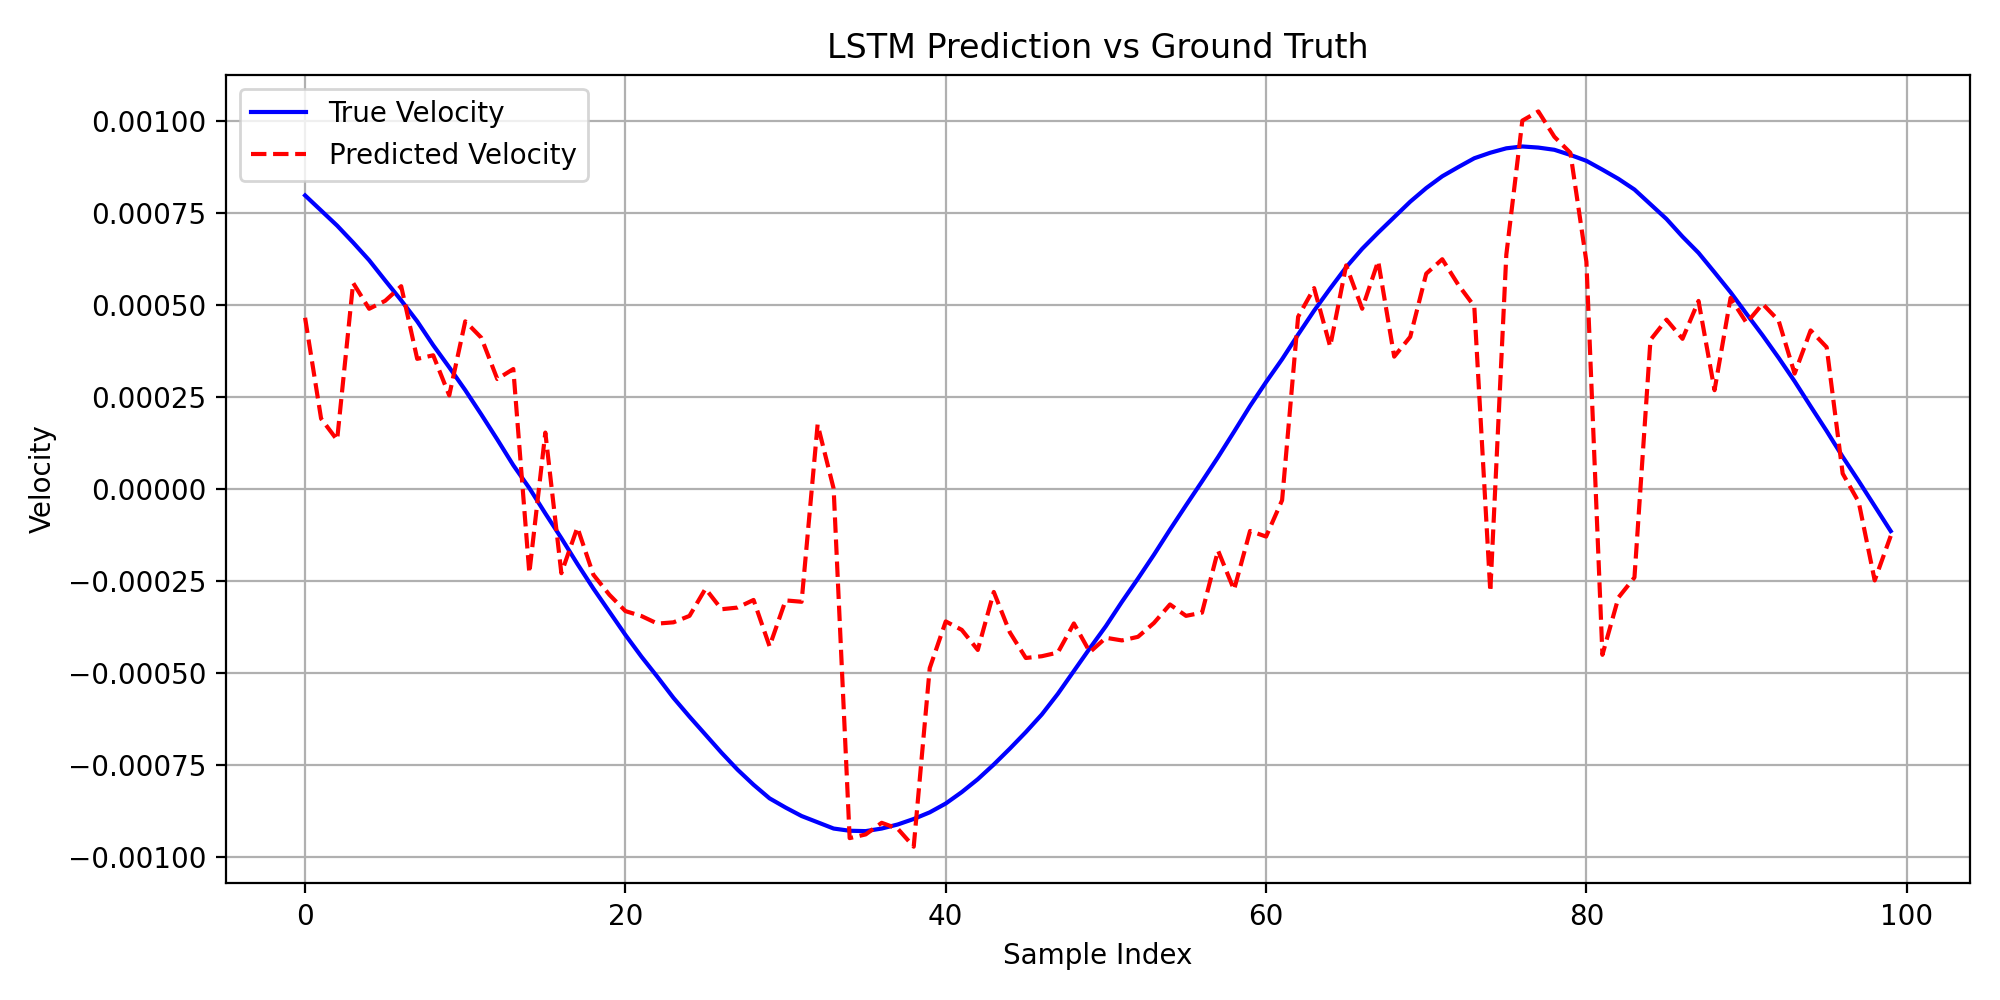

In [70]:
plt.figure(figsize=(10, 5))
plt.plot(y_true[:100], label="True Velocity", color='blue')
plt.plot(y_pred[:100], label="Predicted Velocity", color='red', linestyle='--')
plt.xlabel("Sample Index")
plt.ylabel("Velocity")
plt.title("LSTM Prediction vs Ground Truth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Regression Plot

<IPython.core.display.Javascript object>


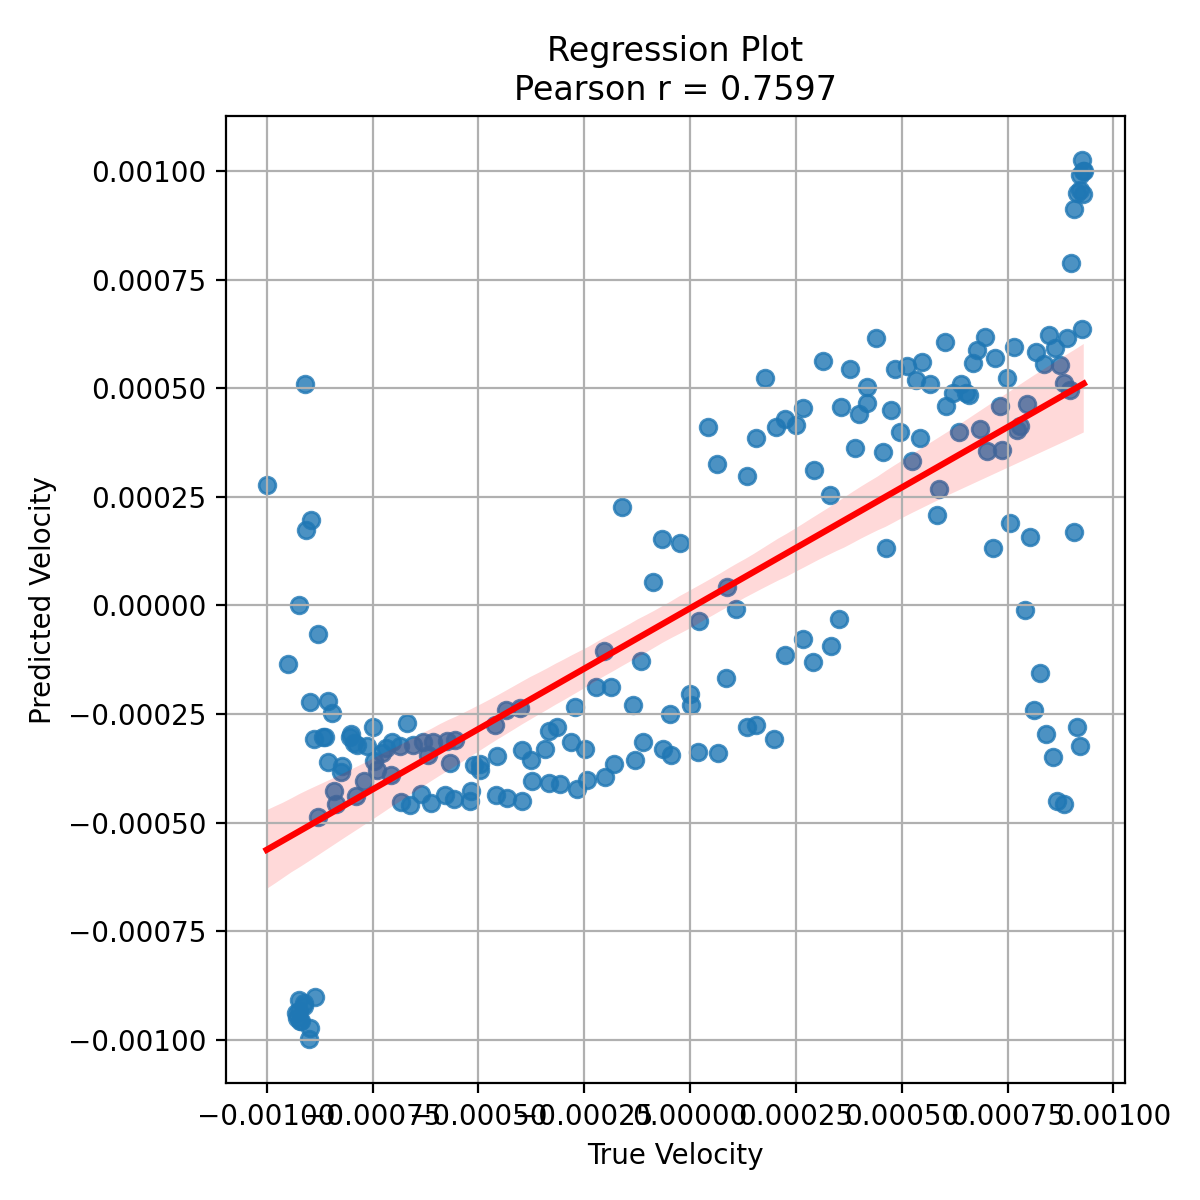

In [71]:
plt.figure(figsize=(6, 6))
sns.regplot(x=y_true.flatten(), y=y_pred.flatten(), line_kws={"color": "red"})
plt.xlabel("True Velocity")
plt.ylabel("Predicted Velocity")
plt.title(f"Regression Plot\nPearson r = {r_value:.4f}")
plt.grid(True)
plt.tight_layout()
plt.show()


# Save Model

In [72]:
save_dir = f"saved_models/{segment_length}"
os.makedirs(save_dir, exist_ok=True)

# Save model with total parameters in the filename
model.save(os.path.join(save_dir, f"{r_value}pearson_{total_params}params.h5"), include_optimizer=False)
print(f"Model saved")

Model saved
